In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.graph_objects as go
import scipy.stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
vax_raw = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv")

# list of countries with continents I found online
countries = pd.read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")


# process data
# the vax data does not have continent information, so I had to add it
# the data also has aggregated data for africa itself (as well as other continents or groups like the EU)
countries = countries[["alpha-3", "region"]]
africa_row = ["OWID_AFR", "Africa"]
countries.loc[len(countries)] = africa_row # add country code for Africa
vax = vax_raw.merge(right=countries, left_on="iso_code", right_on="alpha-3") # add continent info for vax data
vax["date"] = pd.to_datetime(vax["date"])

# get only africa data, should be 54 countries + 1 aggregated
africa_vax = vax[vax["region"] == "Africa"]
len(africa_vax["iso_code"].unique())

# make a chart for country-code correspondence
countries = africa_vax[["location", "iso_code"]].groupby("location").head(1)
new_countries = ['Cabo Verde', 'Congo (Brazzaville)', "Côte d'Ivoire", "Congo (Democratic Republic)", "eSwatini", "São Tomé and Príncipe"]
new_codes = ["CPV", "COG", "CIV", "COD", "SWZ", "STP"]
df_new_countries = pd.DataFrame({"location": new_countries, "iso_code":new_codes})
countries = countries.append(df_new_countries).reset_index().iloc[:,1:]

In [3]:
a = africa_vax[africa_vax["location"]=="Africa"]


(1873618.9294117647, 202273036204.5597)

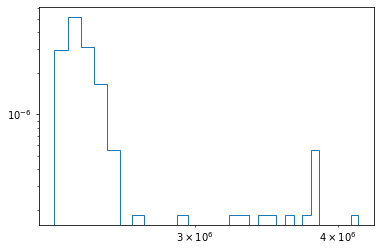

In [5]:
a_recent = a.loc[a.date >= "2/1/2022",:]
plt.hist(a_recent.daily_vaccinations_raw, histtype = 'step', density=True, bins=30)
plt.xscale("log")
plt.yscale("log")

np.mean(a_recent.daily_vaccinations), np.var(a_recent.daily_vaccinations)

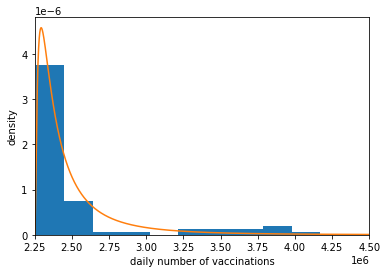

In [35]:
fitted = scipy.stats.lognorm.fit(a_recent.daily_vaccinations_raw)
fitted_pl = scipy.stats.powerlaw.fit(a_recent.daily_vaccinations_raw)
x = np.arange(0,5*10**6,1)
y = scipy.stats.lognorm.pdf(x, s=fitted[0], loc=fitted[1], scale=fitted[2])
y1 = scipy.stats.powerlaw.pdf(x, a=fitted_pl[0], loc=fitted_pl[1], scale=fitted_pl[2])
plt.hist(a_recent.daily_vaccinations_raw, density=True)
plt.plot(x,y)
#plt.plot(x,y1)
plt.xlim(left=2.25*10**6, right=4.5*10**6)
plt.xlabel("daily number of vaccinations")
plt.ylabel("density");

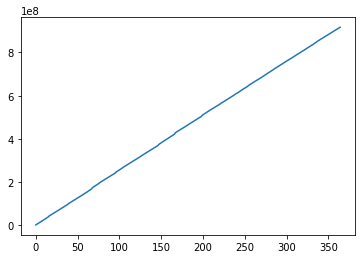

In [7]:
dist = scipy.stats.lognorm(s=fitted[0], loc=fitted[1], scale=fitted[2])
sim = dist.rvs(365)
traj = np.cumsum(sim)
plt.plot(np.arange(365), traj)

result = pd.DataFrame(columns=np.arange(365))

for i in range(1000):
  sim = dist.rvs(365)
  traj = np.cumsum(sim)
  result.loc[i,:] = traj


In [20]:
def time_helper(col):
  m = np.median(col)
  upper = np.percentile(a=col, q=90)
  lower = np.percentile(a=col, q=10)
  return pd.Series([lower, m, upper])

agg = pd.DataFrame(result.apply(func=time_helper, axis=0))
agg

,0,1,2,3,4,5,6,7,8,9,...,355,356,357,358,359,360,361,362,363,364
0,2.285690e+06,4.641690e+06,7.006418e+06,9.416749e+06,1.182334e+07,1.423349e+07,1.666709e+07,1.908536e+07,2.153576e+07,2.394911e+07,...,8.862969e+08,8.887855e+08,8.912365e+08,8.937135e+08,8.962063e+08,8.987947e+08,9.012914e+08,9.038021e+08,9.062936e+08,9.087811e+08
1,2.404931e+06,4.875570e+06,7.363314e+06,9.861714e+06,1.236643e+07,1.487228e+07,1.738885e+07,1.987716e+07,2.237973e+07,2.488581e+07,...,8.954740e+08,8.980024e+08,9.005303e+08,9.029664e+08,9.055448e+08,9.079640e+08,9.106242e+08,9.130902e+08,9.155581e+08,9.180657e+08
2,2.861153e+06,5.587312e+06,8.271316e+06,1.086928e+07,1.351027e+07,1.617486e+07,1.887937e+07,2.141233e+07,2.402144e+07,2.653339e+07,...,9.065683e+08,9.091678e+08,9.116085e+08,9.141150e+08,9.165310e+08,9.190997e+08,9.216888e+08,9.241040e+08,9.267441e+08,9.293704e+08


In [38]:
af = africa_vax[africa_vax["location"]=="Africa"]
af

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred,alpha-3,region
421,Africa,OWID_AFR,2021-01-09,0.0,0.0,NaN,NaN,0.0,0.0,0.00,0.00,NaN,NaN,0.0,0.0,0.000,OWID_AFR,Africa
422,Africa,OWID_AFR,2021-01-10,0.0,0.0,NaN,NaN,0.0,500.0,0.00,0.00,NaN,NaN,0.0,500.0,0.000,OWID_AFR,Africa
423,Africa,OWID_AFR,2021-01-11,0.0,0.0,NaN,NaN,0.0,500.0,0.00,0.00,NaN,NaN,0.0,500.0,0.000,OWID_AFR,Africa
424,Africa,OWID_AFR,2021-01-12,0.0,0.0,NaN,NaN,0.0,500.0,0.00,0.00,NaN,NaN,0.0,500.0,0.000,OWID_AFR,Africa
425,Africa,OWID_AFR,2021-01-13,2000.0,2000.0,NaN,NaN,0.0,500.0,0.00,0.00,NaN,NaN,0.0,500.0,0.000,OWID_AFR,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
889,Africa,OWID_AFR,2022-04-22,474207891.0,291821466.0,221964905.0,20238551.0,2314361.0,2163358.0,34.53,21.25,16.16,1.47,1575.0,984810.0,0.072,OWID_AFR,Africa
890,Africa,OWID_AFR,2022-04-23,474293394.0,291850979.0,221996264.0,20270068.0,2327587.0,2173134.0,34.53,21.25,16.16,1.48,1582.0,987140.0,0.072,OWID_AFR,Africa
891,Africa,OWID_AFR,2022-04-24,474293394.0,291850979.0,221996264.0,20270068.0,2327587.0,2172999.0,34.53,21.25,16.16,1.48,1582.0,986891.0,0.072,OWID_AFR,Africa
892,Africa,OWID_AFR,2022-04-25,474315105.0,291860156.0,222002407.0,20277093.0,2327587.0,2172991.0,34.53,21.25,16.16,1.48,1582.0,986688.0,0.072,OWID_AFR,Africa


In [49]:
end_date = af["date"][893]
ranges = pd.date_range(start="4/27/22", end="12/31/22")

,0,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,16.263984,16.360859,16.458093,16.557202,16.656157,16.755259,16.855325,16.954760,17.055517,17.154749,...,40.674546,40.777002,40.879718,40.977857,41.089015,41.191362,41.297409,41.403203,41.504861,41.605817
1,16.268887,16.370476,16.472768,16.575498,16.678488,16.781525,16.885002,16.987318,17.090219,17.193265,...,40.997047,41.095796,41.198342,41.297237,41.400287,41.503379,41.604722,41.707742,41.816791,41.918928
2,16.287646,16.399741,16.510103,16.616928,16.725521,16.835085,16.946290,17.050441,17.157724,17.261011,...,41.354624,41.456809,41.558386,41.670323,41.773462,41.878369,41.981394,42.083228,42.190638,42.287833


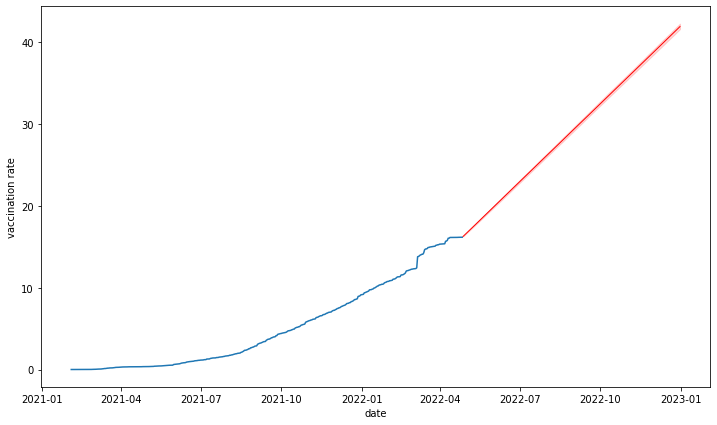

In [83]:
raw = af["daily_vaccinations_raw"]
processed = np.cumsum(raw) / (2*1.216*10**9) *100
new = agg.loc[:,:248] / (2*1.216*10**9) *100 + 16.17
new1 = new.loc[1,:]
new_lower = new.loc[0,:]
new_upper = new.loc[2,:]

plt.subplots(figsize=(12,7))
plt.plot(af["date"], af["people_fully_vaccinated_per_hundred"])
plt.plot(ranges, new1, linewidth=1, color="r")
plt.fill_between(ranges, new_lower, new_upper, color='r', alpha=.15);
plt.xlabel("date")
plt.ylabel("vaccination rate");
new

0    41.697772
1    42.017089
2    42.380307
Name: 249, dtype: float64

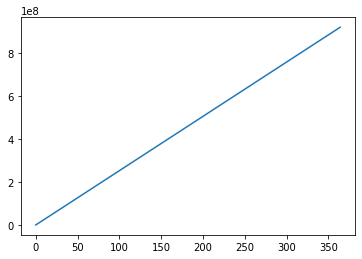

In [32]:
plt.plot(np.arange(365), agg.loc[1,:])

(agg.loc[:,249] / (2*1.216*10**9)) *100 + 16.16